In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import anndata
import string
import gc
from anndata import read_h5ad
from anndata import read_csv
from pandas import DataFrame
import h5py
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import networkx as nx
import plotly.graph_objects as go
import scanpy as sc
import dill
from adjustText import adjust_text

/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)


In [2]:
dill.load_session('sessions/002-pairwise_correlation_pca.pkl')

In [58]:
dill.dump_session('sessions/002-pairwise_correlation_pca.pkl')

## LOAD DATA

In [2]:
adata_tf = read_h5ad(os.path.join('..', 'data', 'adata_tf.h5ad'))
adata_tf_copy = adata_tf.copy()

## CALCULATE PCA

In [3]:
sc.tl.pca(adata_tf_copy, n_comps=50, svd_solver='arpack')
adata_tf_copy.obsm['X_pca']

array([[ 3.441468  ,  4.522237  , -1.2851397 , ...,  0.60081375,
        -0.670879  , -1.107567  ],
       [ 1.7431852 , -3.5806558 ,  5.894796  , ..., -0.0658133 ,
         0.24725899, -0.1055054 ],
       [ 3.7293823 , -1.8634572 ,  5.240303  , ..., -0.38052496,
         0.6495772 , -0.22579733],
       ...,
       [ 7.3735113 ,  1.0802875 ,  3.2002892 , ...,  0.92885613,
        -0.4907385 , -0.50389403],
       [-3.9553823 ,  1.1896985 ,  1.4690025 , ..., -1.2855725 ,
        -0.8527264 , -0.6619931 ],
       [ 2.4677057 ,  0.9412613 , -0.54306126, ...,  0.2692278 ,
         1.4657577 ,  0.7285391 ]], dtype=float32)

## CLUSTERING

In [4]:
# Compute the neighborhood graph based on PCA
sc.pp.neighbors(adata_tf_copy, n_neighbors=15, n_pcs=30)  # Adjust n_neighbors and n_pcs as needed

# Cluster cells using Leiden algorithm
sc.tl.leiden(adata_tf_copy, resolution=1.0)  # Adjust resolution for desired cluster granularity

/tmp/ipykernel_86465/2617619722.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_tf_copy, resolution=1.0)  # Adjust resolution for desired cluster granularity


## VISUALIZE

In [ ]:
# Compute UMAP based on transcription factors
sc.tl.umap(adata_tf_copy)

In [21]:
# Transfer the UMAP embedding and connectivities etc. to the original adata object
adata_tf.obsm['X_tf_umap'] = adata_tf_copy.obsm['X_umap']
adata_tf.uns['tf_neighbors'] = adata_tf_copy.uns['neighbors']
adata_tf.obs['tf_leiden'] = adata_tf_copy.obs['leiden']
adata_tf.obsp['tf_connectivities'] = adata_tf_copy.obsp['connectivities']

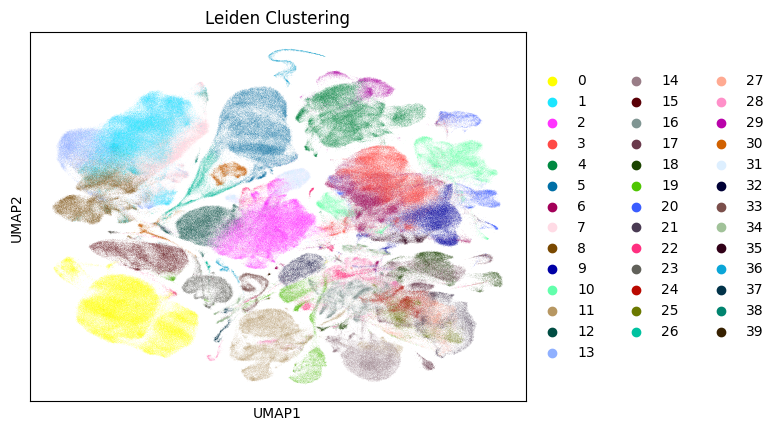

In [ ]:
# Plot UMAP with cluster identities from transcription factor clustering
sc.pl.umap(adata_tf, neighbors_key='connectivities', color=['tf_leiden'], title='Leiden Clustering')

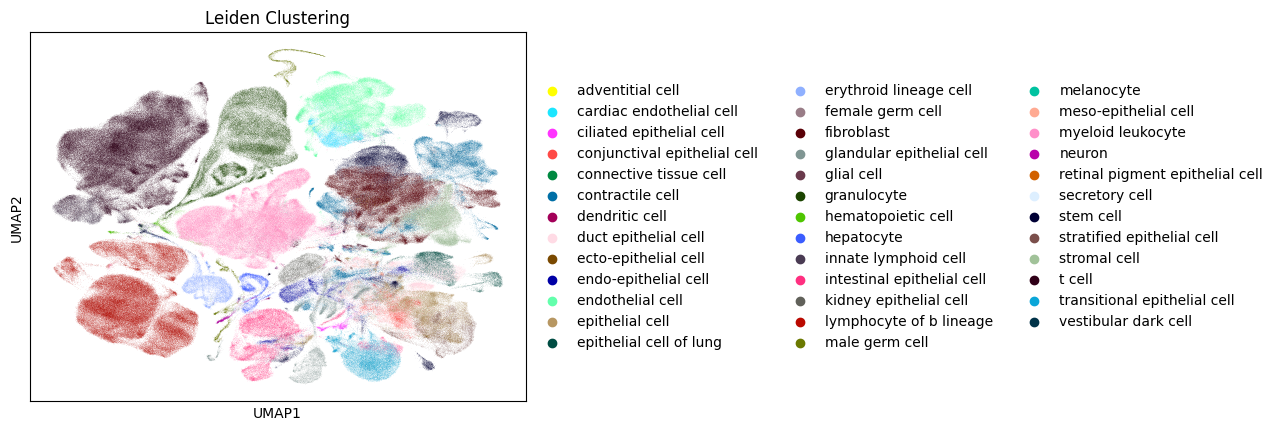

In [ ]:
# Plot UMAP with broad cell class identities
sc.pl.umap(adata_tf, color=['broad_cell_class'], title='Leiden Clustering')

The plots show that there are two subpopulations of B cells ('lymphocyte of b lineage') distinct in their transcription factor expression profiles

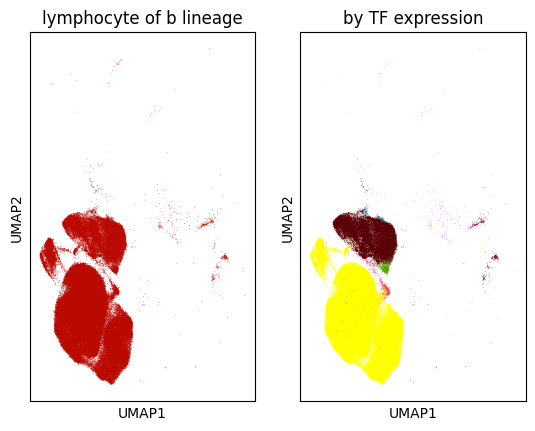

In [49]:
fig, ax = plt.subplots(1, 2)
sc.pl.umap(adata_tf[(adata_tf.obs['broad_cell_class'] == 'lymphocyte of b lineage')], color=['broad_cell_class'], title='lymphocyte of b lineage', ax=ax[0], legend_loc=None, show=False)
sc.pl.umap(adata_tf[(adata_tf.obs['broad_cell_class'] == 'lymphocyte of b lineage')], color=['tf_leiden'], title='by TF expression', ax=ax[1], legend_loc=None, show=False)
fig.show()

What are the differences between their transcription factor expression profiles

In [34]:
adata_b_cells = adata_tf[(adata_tf.obs['broad_cell_class'] == 'lymphocyte of b lineage') & ((adata_tf.obs['tf_leiden'] == '0') | (adata_tf.obs['tf_leiden'] == '15'))]

# filter out genes that are not expressed in more than three cells from any of the two subpopulations
sc.pp.filter_genes(adata_b_cells, min_cells=3)

# Perform differential expression analysis
sc.tl.rank_genes_groups(
    adata_b_cells,
    groupby='tf_leiden',       # Column defining the groups
    groups=['0'],              # Compare group '0'
    reference='15',            # Against group '15'
    method='wilcoxon',         # Use Wilcoxon rank-sum test
    use_raw=False              # Use the current .X matrix, not .raw
)

/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:284: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [35]:
# Extract results for group '0'
results = adata_b_cells.uns['rank_genes_groups']
group = '0'  # Group of interest

# Create a DataFrame
dge_results = pd.DataFrame({
    'gene': results['names'][group],
    'logfoldchange': results['logfoldchanges'][group],
    'pvals_adj': results['pvals_adj'][group],  # Adjusted p-values
    'pvals': results['pvals'][group],          # Raw p-values
    'scores': results['scores'][group]         # Wilcoxon scores
})
print(dge_results.head())

    gene  logfoldchange  pvals_adj  pvals      scores
0  BACH2       4.771125        0.0    0.0  205.422028
1    REL       4.454690        0.0    0.0  198.603729
2   EBF1       4.730068        0.0    0.0  194.998032
3   IRF8       5.681445        0.0    0.0  192.302246
4  SP100       2.564513        0.0    0.0  191.365280


[Text(4.771124839782715, inf, 'BACH2'), Text(4.4546895027160645, inf, 'REL'), Text(4.730067729949951, inf, 'EBF1'), Text(5.6814446449279785, inf, 'IRF8'), Text(2.5645129680633545, inf, 'SP100'), Text(4.84243106842041, inf, 'PAX5'), Text(4.7123799324035645, inf, 'BCL11A'), Text(3.4291882514953613, inf, 'SP110'), Text(4.075808048248291, inf, 'JAZF1'), Text(1.9104018211364746, inf, 'ZBTB20'), Text(2.207176446914673, inf, 'PHF20'), Text(1.4597926139831543, inf, 'ELF1'), Text(1.7360447645187378, inf, 'PRDM2'), Text(1.9484211206436157, inf, 'POU2F2'), Text(2.521601438522339, inf, 'NR4A2'), Text(2.920623779296875, inf, 'ZNF331'), Text(1.4269572496414185, inf, 'JUND'), Text(1.384881615638733, inf, 'ARID5B'), Text(1.8218296766281128, inf, 'BBX'), Text(4.088296890258789, inf, 'SMAD3')]


/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_112802/413854541.py:37: RuntimeWarning: divide by zero encountered in log10
  -np.log10(row['pvals_adj']),
/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/matplotlib/transforms.py:357: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 1] - points[0, 1]


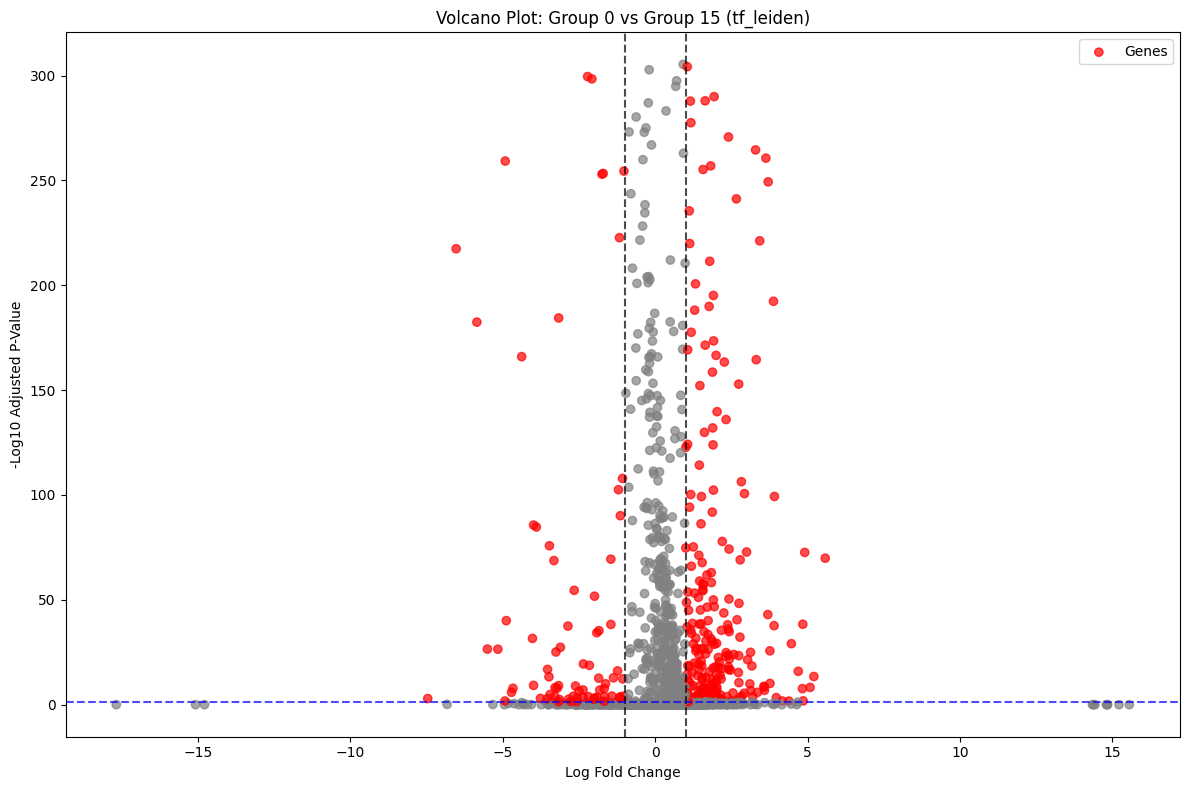

In [36]:
# Volcano plot parameters
significance_threshold = 0.05  # Adjusted p-value threshold
logfc_threshold = 1.0          # Log fold change threshold

# Highlight significant genes
dge_results['significant'] = (
    (dge_results['pvals_adj'] < significance_threshold) & 
    (abs(dge_results['logfoldchange']) > logfc_threshold)
)

# Calculate transformed adjusted p-values
dge_results['pvals_adj_transf'] = -np.log10(dge_results['pvals_adj'])

# Select the 20 most interesting genes based on p-value and log fold change
top_genes = dge_results.nsmallest(20, 'pvals_adj')

# Volcano plot
plt.figure(figsize=(12, 8))
plt.scatter(
    dge_results['logfoldchange'], 
    -np.log10(dge_results['pvals_adj']), 
    c=dge_results['significant'].map({True: 'red', False: 'gray'}),
    alpha=0.7, label='Genes'
)

# Add labels and thresholds
plt.axvline(x=logfc_threshold, linestyle='--', color='black', alpha=0.7)
plt.axvline(x=-logfc_threshold, linestyle='--', color='black', alpha=0.7)
plt.axhline(y=-np.log10(significance_threshold), linestyle='--', color='blue', alpha=0.7)

# Annotate the 20 most interesting genes
texts = []
for _, row in top_genes.iterrows():
    texts.append(
        plt.text(
            row['logfoldchange'], 
            -np.log10(row['pvals_adj']), 
            row['gene'], 
            fontsize=9, 
            color='black'
        )
    )

print(texts)

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

# Add labels and title
plt.xlabel('Log Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot: Group 0 vs Group 15 (tf_leiden)')
plt.legend(loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
dge_results

,gene,logfoldchange,pvals_adj,pvals,scores,significant,pvals_adj_transf
0,BACH2,4.771125,0.0,0.0,205.422028,True,inf
1,REL,4.454690,0.0,0.0,198.603729,True,inf
2,EBF1,4.730068,0.0,0.0,194.998032,True,inf
3,IRF8,5.681445,0.0,0.0,192.302246,True,inf
4,SP100,2.564513,0.0,0.0,191.365280,True,inf
...,...,...,...,...,...,...,...
1569,ZBTB38,-1.980668,0.0,0.0,-127.873138,True,inf
1570,ESR1,-3.473601,0.0,0.0,-133.855896,True,inf
1571,CREB3L2,-3.166899,0.0,0.0,-167.531464,True,inf
1572,PRDM1,-4.833344,0.0,0.0,-205.770905,True,inf


In [38]:
dge_results[(dge_results['pvals_adj'] != 0) & (dge_results['logfoldchange'] < -1)].sort_values(by='pvals_adj').head(10)

,gene,logfoldchange,pvals_adj,pvals,scores,significant,pvals_adj_transf
1493,TET1,-2.218659,2.926620e-300,3.291053e-301,-37.095737,True,299.533634
1492,CENPA,-2.077018,3.781707e-299,4.276645e-300,-37.026592,True,298.422312
1484,E2F7,-4.920580,5.993730e-260,7.501682e-261,-34.501942,True,259.222303
1483,BATF,-1.024929,3.749953e-255,4.764870e-256,-34.180176,True,254.425974
1482,GLMP,-1.704897,4.849471e-254,6.192781e-255,-34.105122,True,253.314306
1481,ZNF367,-1.748444,1.113948e-253,1.429590e-254,-34.080605,True,252.953135
1476,FOSL2,-1.173560,1.996507e-223,2.663700e-224,-31.972103,True,222.699729
1474,E2F8,-6.531640,3.849599e-218,5.233889e-219,-31.588966,True,217.414585
1466,E2F1,-3.166859,3.980142e-185,5.815964e-186,-29.083435,True,184.400101
1465,GFI1,-5.851830,3.810796e-183,5.616930e-184,-28.926048,True,182.418984


In [39]:
sum(results['pvals_adj']['0'] == 0)

np.int64(173)

In [14]:
for _, row in top_genes.iterrows():
    print(row['pvals_adj'])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [11]:
top_genes

,gene,logfoldchange,pvals_adj,pvals,scores,significant
0,BACH2,4.771125,0.0,0.0,205.422028,True
1,REL,4.454690,0.0,0.0,198.603729,True
2,EBF1,4.730068,0.0,0.0,194.998032,True
3,IRF8,5.681445,0.0,0.0,192.302246,True
4,SP100,2.564513,0.0,0.0,191.365280,True
5,PAX5,4.842431,0.0,0.0,176.113220,True
6,BCL11A,4.712380,0.0,0.0,164.228348,True
7,SP110,3.429188,0.0,0.0,163.922394,True
8,JAZF1,4.075808,0.0,0.0,154.917862,True
9,ZBTB20,1.910402,0.0,0.0,150.092041,True


In [9]:
# Generate a heatmap of cluster-specific genes
sc.pl.matrixplot(adata_tf, adata_tf.var_names, groupby='leiden', cmap='viridis')

: 

: 

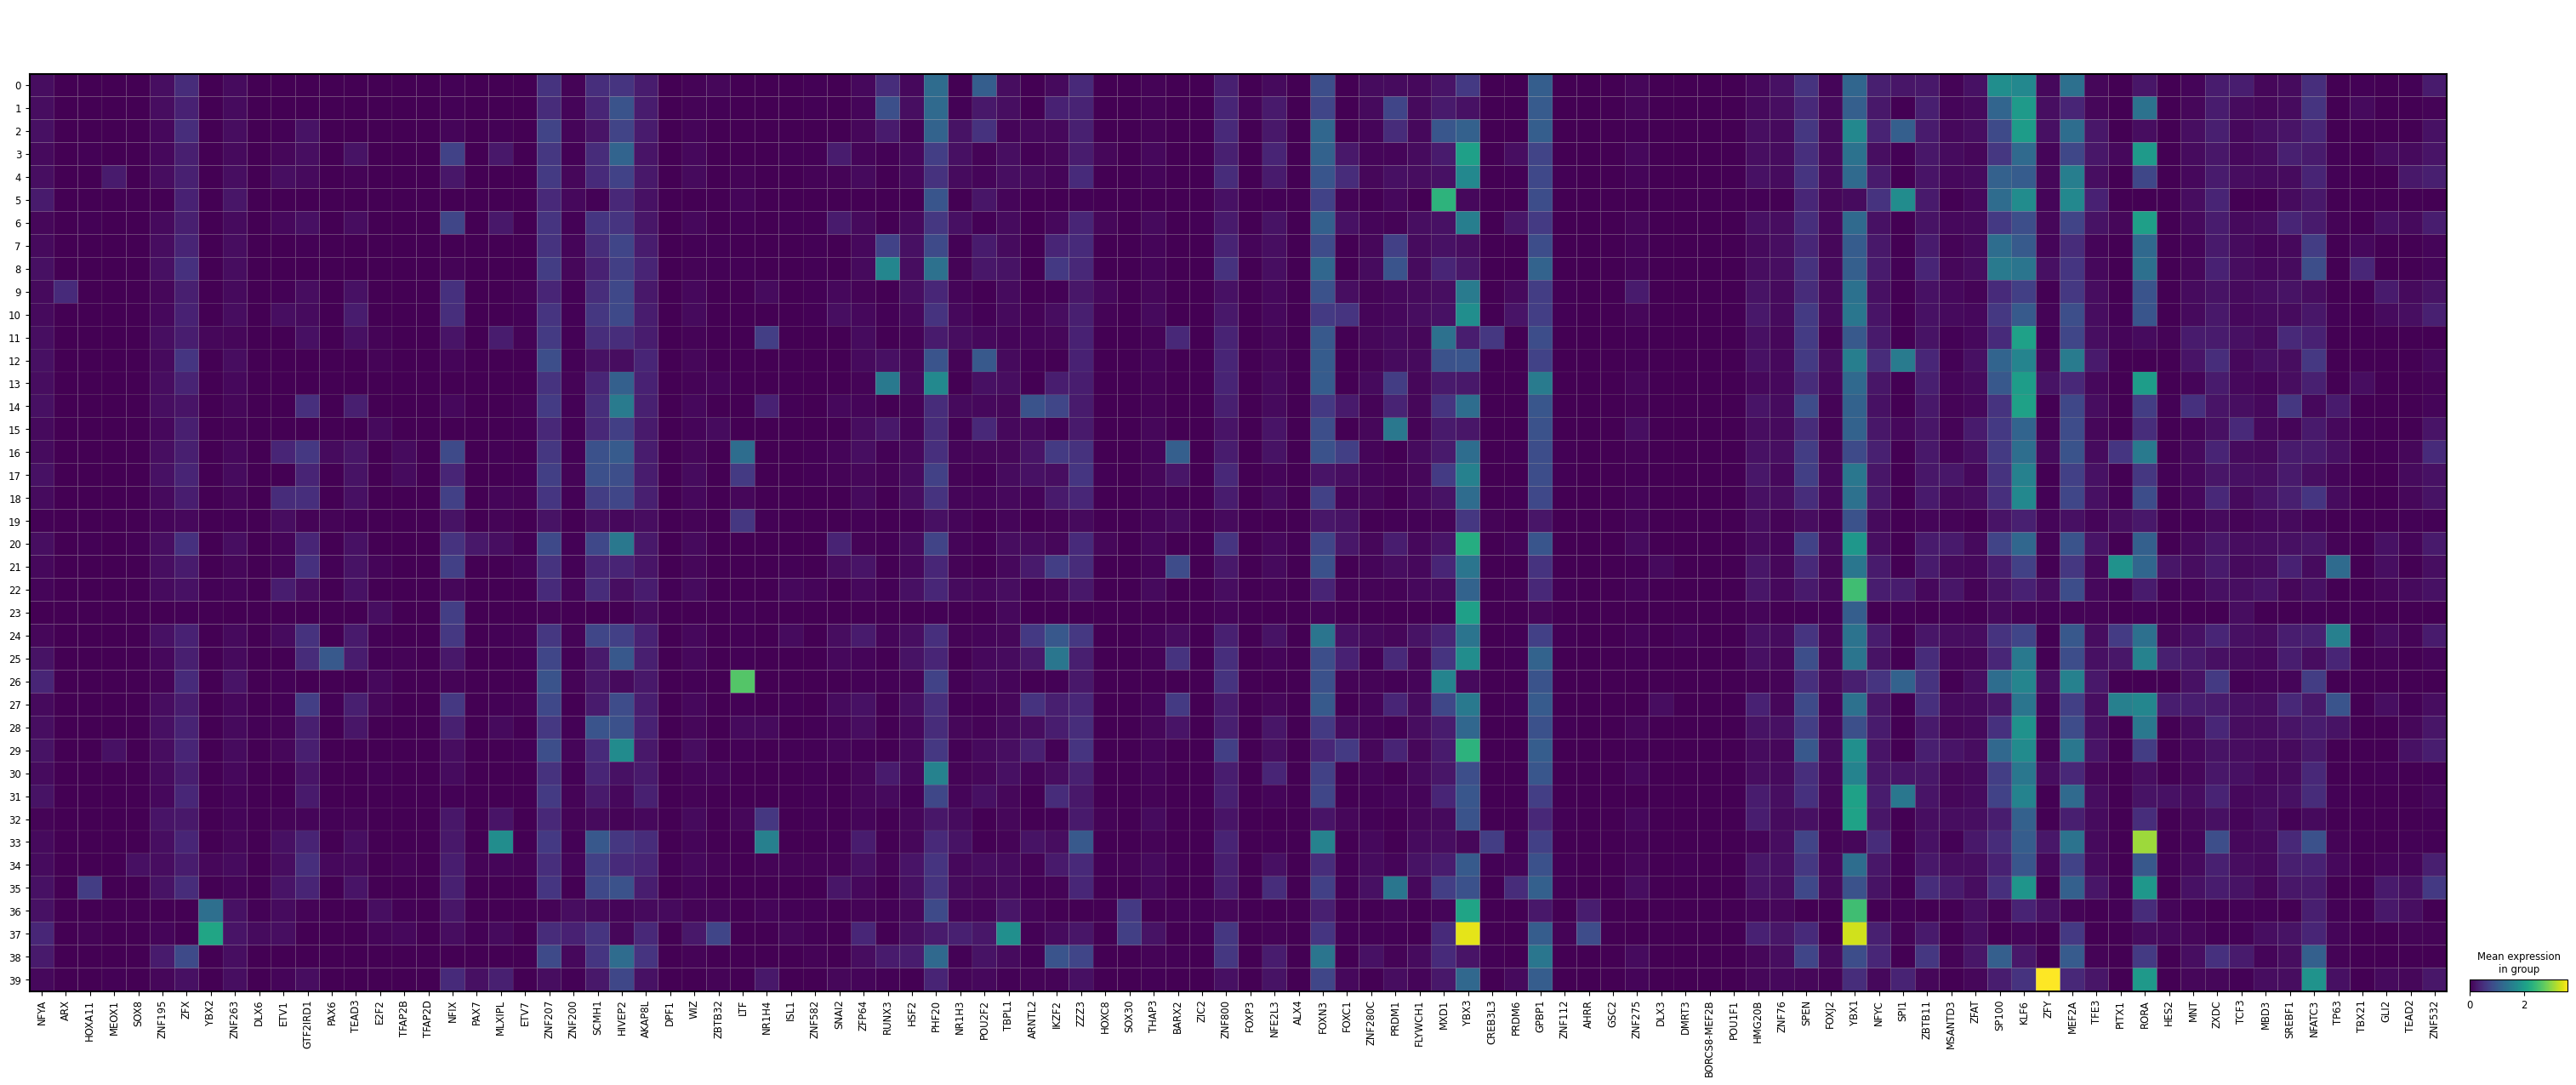

: 

: 

In [10]:
sc.pl.matrixplot(adata_tf, adata_tf.var_names[0:100], groupby='leiden', cmap='viridis')

<Axes: title={'center': 'Cluster Sizes'}, xlabel='leiden'>

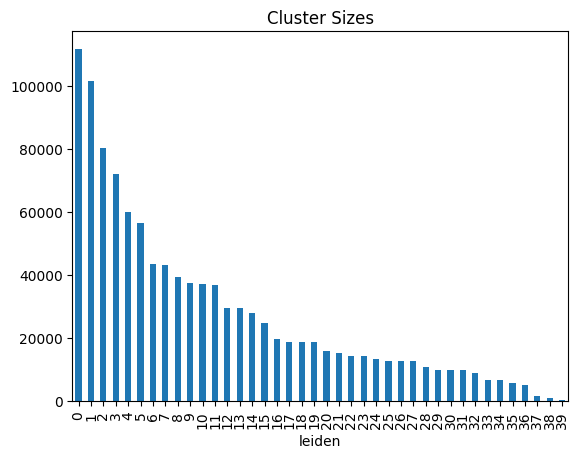

: 

: 

In [13]:
# Cluster sizes
adata_tf.obs['leiden'].value_counts().plot(kind='bar', title='Cluster Sizes')

/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_g

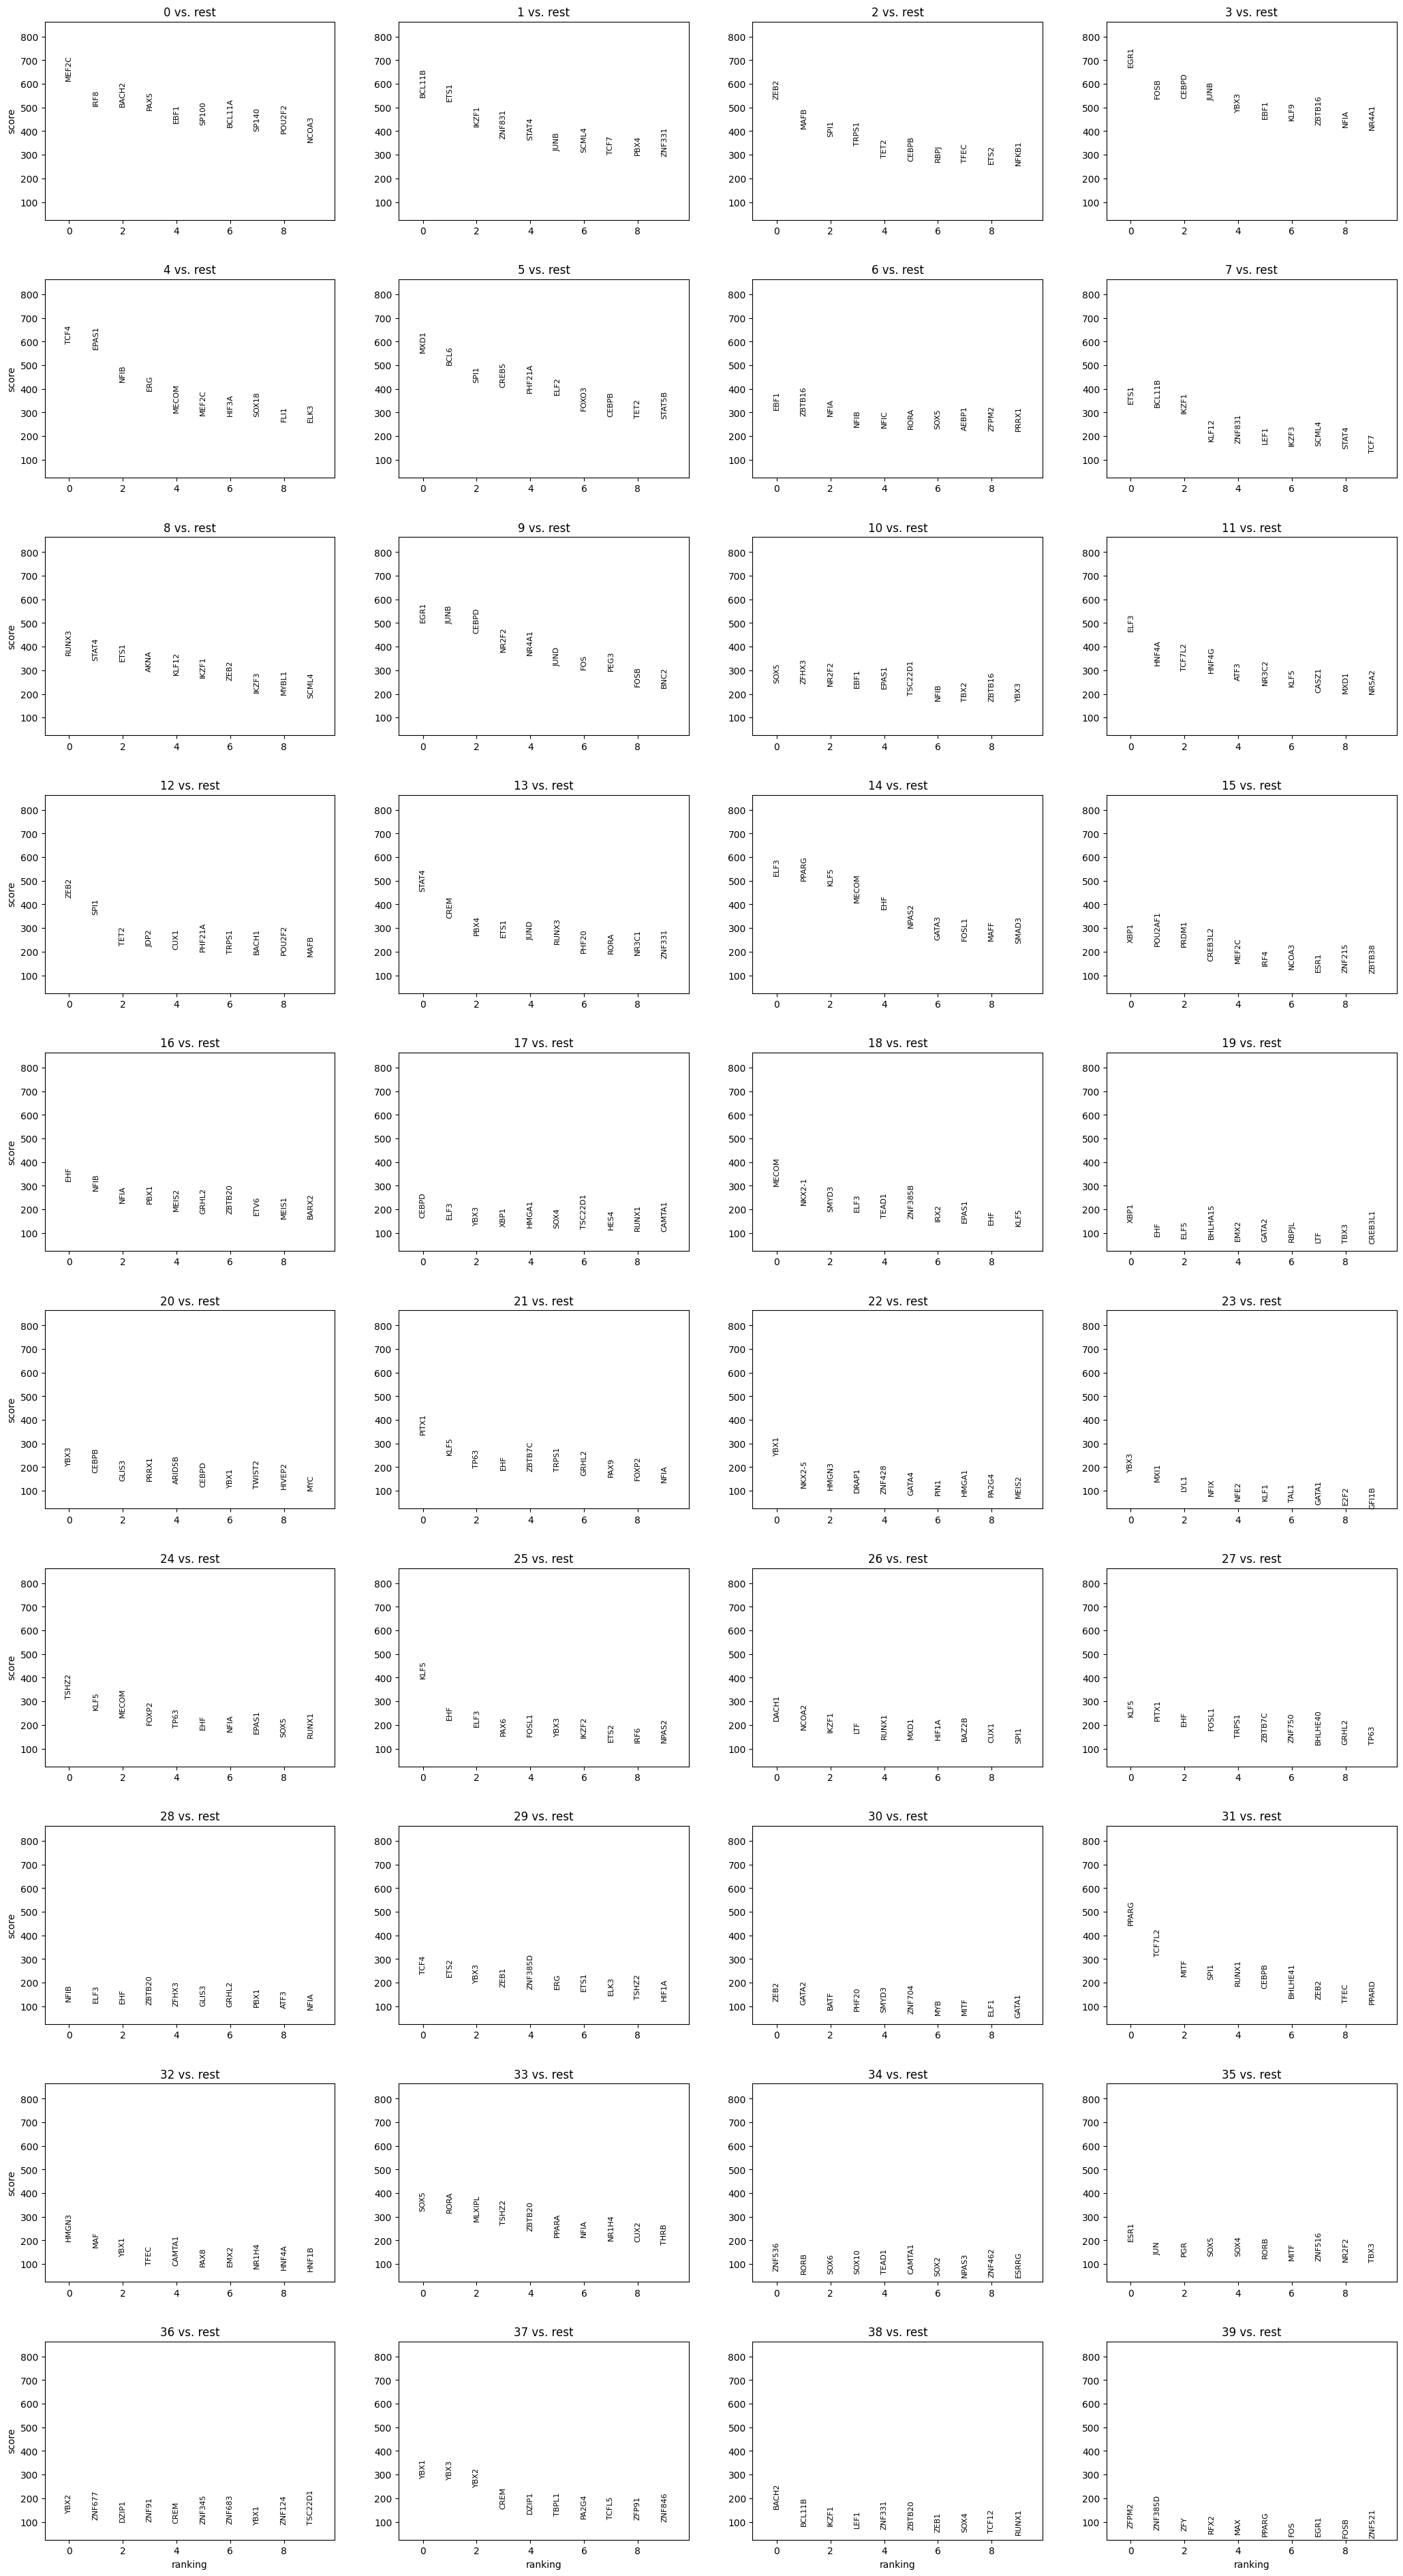

: 

: 

In [14]:
sc.tl.rank_genes_groups(adata_tf, groupby='leiden', method='t-test')
sc.pl.rank_genes_groups(adata_tf, n_genes=10)

In [1]:
adata_tf

NameError: name 'adata_tf' is not defined

: 

: 